# Dataset Preparation for First ICU Prediction

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import pandas as pd
import spacy

import seaborn as sns
sns.set(style = 'darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

In [3]:
path = Path('./data')
raw_csv = path/'mimic_icu_pred_raw_dataset.csv'
proc_csv = path/'mimic_icu_pred_proc_dataset.csv'
fig_dir = path/'workdir/figures'

## Functions

In [ ]:
def get_sample(df, sample_pct=0.01, with_val=True, seed=None):
  train = df.loc[(df['split']) == 'train'].sample(frac=sample_pct, random_state=seed)
  train.reset_index(inplace=True, drop=True)

  if with_val:
    val = df.loc[(df['split']) == 'val'].sample(frac=sample_pct, random_state=seed)
    val.reset_index(inplace=True, drop=True)
    return pd.concat([train, val], axis=0) 

  return train

In [ ]:
def tokenize_text(text):
  tokens = [token.text for token in nlp(text)]
  return ' '.join(tokens)

def group_eth(eth):
  eth = eth.lower()
  if 'white' in eth:
    return 'white'
  elif 'black' in eth:
    return 'black'
  elif 'hispanic' in eth:
    return 'hispanic'
  elif 'asian' in eth:
    return 'asian'
  else:
    return 'unknown'

## Data Processing

1. Load in the data
2. Drop duplicates
3. Merge `category`, `description`, and `text` into a new column called `note`
4. Tokenize text using `scispacy` and create new column called `scispacy_note` to save tokenized text
5. Save a csv file onto disk

In [ ]:
df = pd.read_csv(raw_csv)
df.shape

In [ ]:
nlp = spacy.load('en_core_sci_md', disable=['parser', 'ner', 'tagger'])

df.drop_duplicates(inplace=True)
df['note'] = df['category'].str.cat(df['description'], sep='\n')
df['note'] = df['note'].str.cat(df['text'], sep='\n')
df['ethnicity'] = df['ethnicity'].apply(group_eth)
df['scispacy_note'] = df['note'].apply(tokenize_text)
df.shape

In [ ]:
df.to_csv(proc_csv, index=False)

## Data Analysis

In [4]:
df = pd.read_csv(proc_csv)
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'admission_type', 'admittime',
       'dischtime', 'intime', 'outtime', 'charttime', 'icu_los', 'deathtime',
       'adm_icu_period', 'chart_icu_period', 'chartinterval', 'ethnicity',
       'dob', 'gender', 'admission_age', 'category', 'description', 'text',
       'imminent_label', 'discharge_label', 'note', 'scispacy_note'],
      dtype='object')

In [5]:
intervals = ['-1 ≤ t ≤ 0']
intervals += [f'-{i+1} ≤ t ≤ -{i}' for i in range(1, 15)]
intervals.append('t ≤ -15')

### ICU LOS Histogram

In [6]:
plot_df = df[['icu_los']]

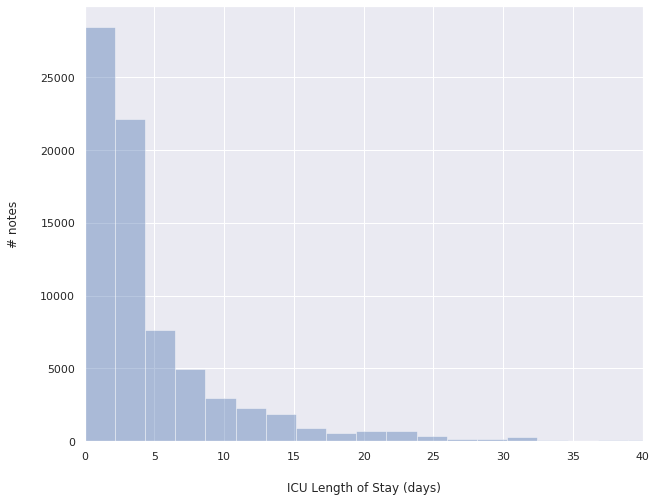

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df, kde=False, ax=ax, bins=80)
ax.set_xlabel('ICU Length of Stay (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 40)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
# fig.savefig(fig_dir/'icu_los_hist.tif', dpi=300)
# ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {df['icu_los'].min()}, Avg: {df['icu_los'].mean(): 0.2f}, Max: {df['icu_los'].max()}", fontsize=15, ha='center', va='bottom')

### Bar Plot of notes grouped by category over days

In [8]:
plot_df = pd.DataFrame(df.groupby(['category', 'chartinterval']).size(), columns=['n_notes'])
plot_df.reset_index(inplace=True)
plot_df['days'] = plot_df['chartinterval'].apply(lambda x: intervals[x])
plot_df.drop(['chartinterval'], inplace=True, axis=1)
plot_df.head()

,category,n_notes,days
0,Case Management,1,-2 ≤ t ≤ -1
1,Case Management,2,-3 ≤ t ≤ -2
2,Case Management,2,-4 ≤ t ≤ -3
3,Case Management,4,-5 ≤ t ≤ -4
4,Case Management,3,-6 ≤ t ≤ -5


In [9]:
def plot_intervals(df, cat, ax):    
    sns.barplot(x='days', y='n_notes', data=df, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f"Note Category: {cat}\n# notes: {df['n_notes'].sum()}")   

    for index, (_, row) in enumerate(df.iterrows()):
        ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom')    

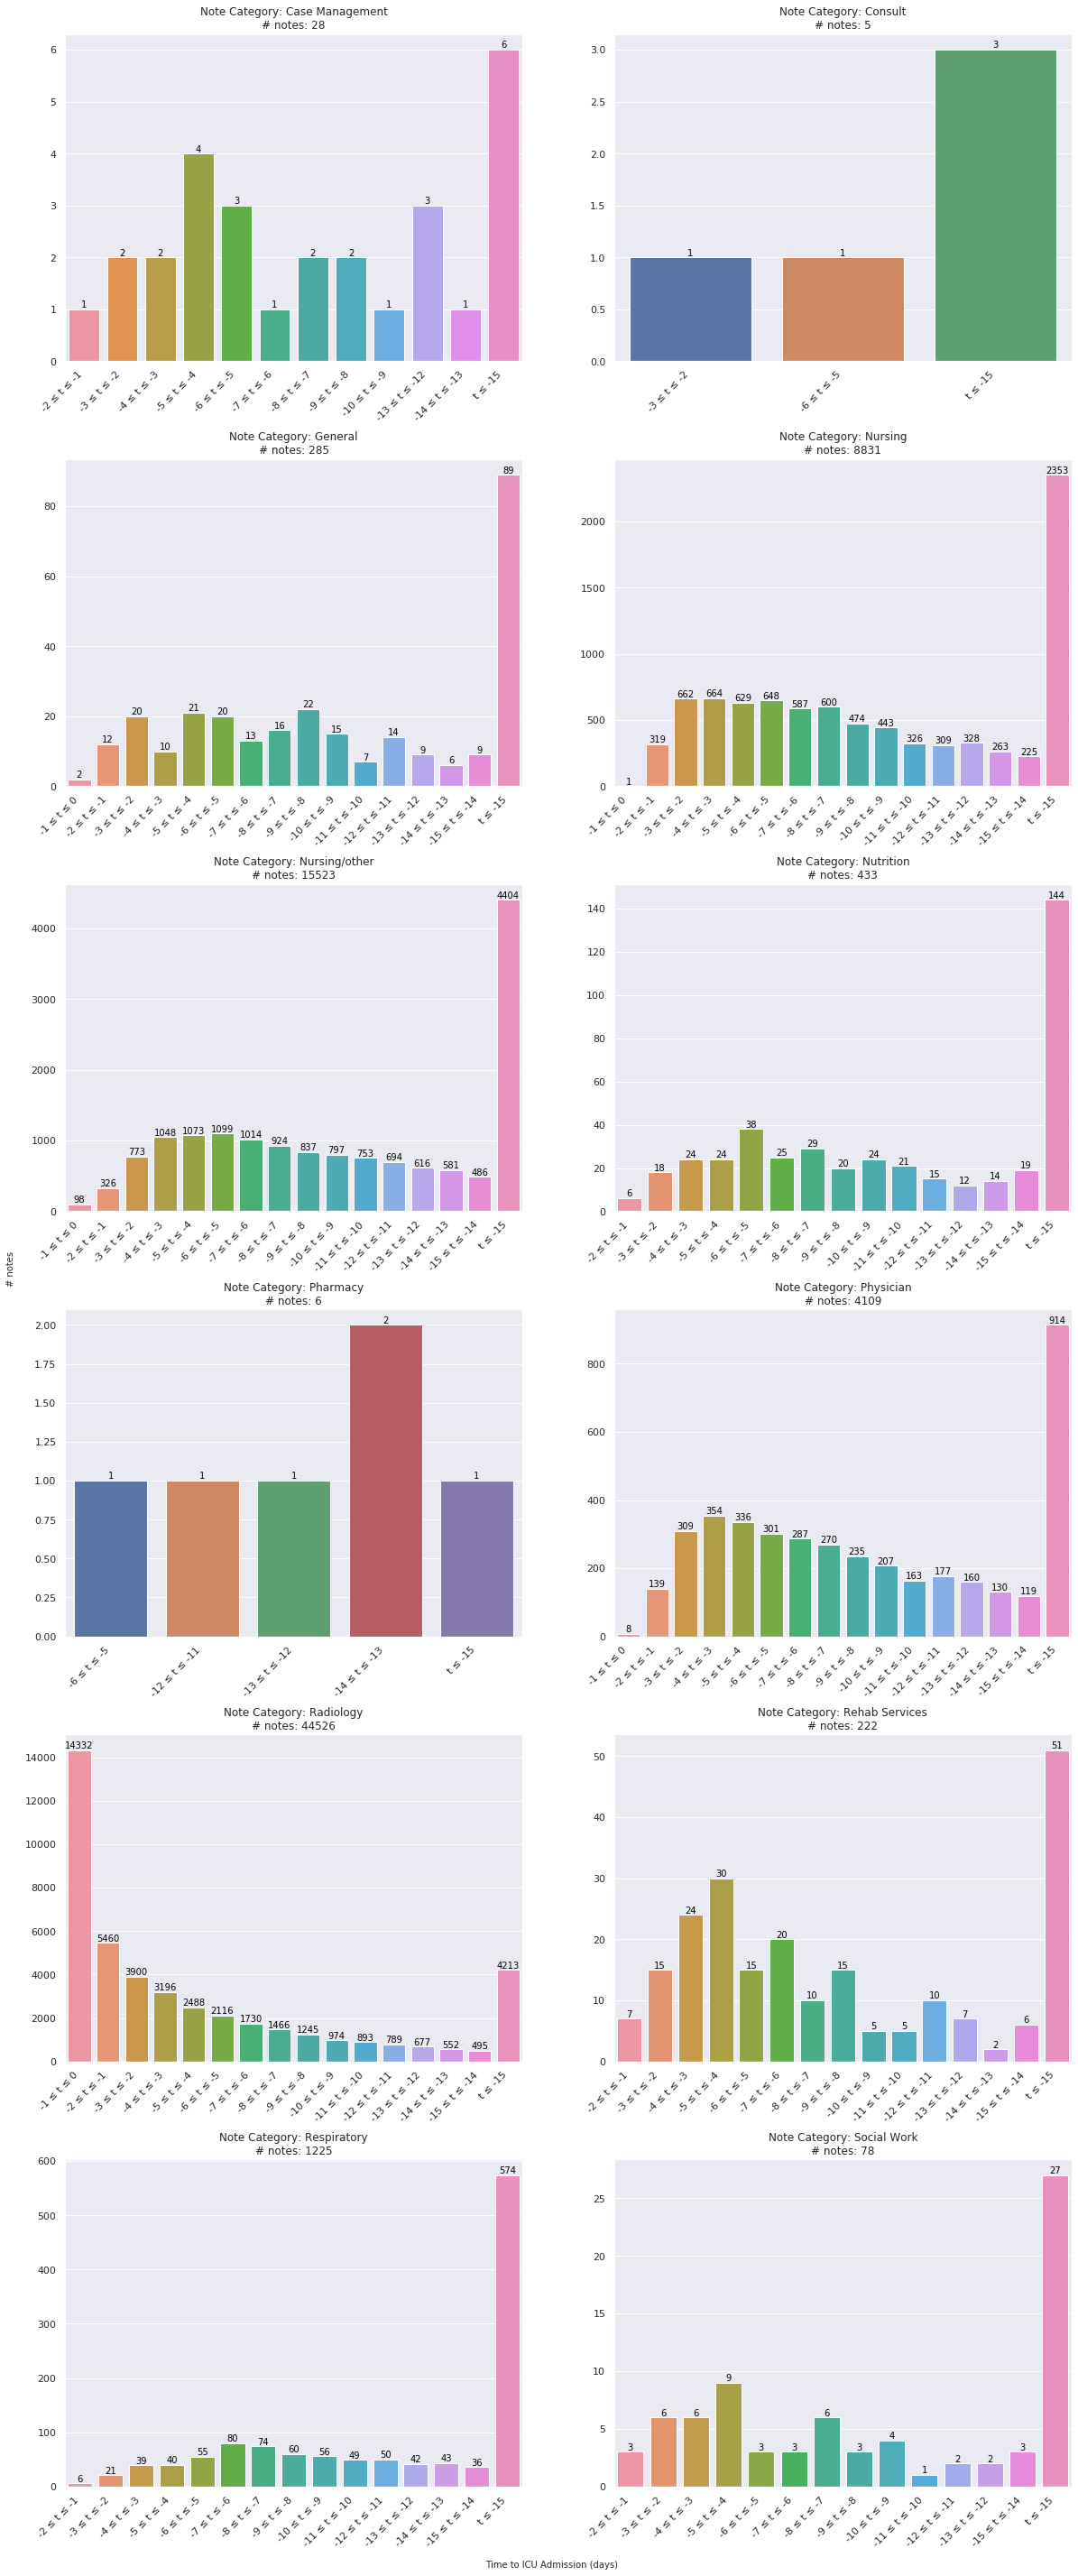

In [11]:
fig, ax = plt.subplots(6, 2, figsize=(20, 50))
plot_intervals(plot_df.loc[plot_df['category'] == 'Case Management ', ['n_notes', 'days']], 'Case Management', ax[0][0])
plot_intervals(plot_df.loc[plot_df['category'] == 'Consult', ['n_notes', 'days']], 'Consult', ax[0][1])
plot_intervals(plot_df.loc[plot_df['category'] == 'General', ['n_notes', 'days']], 'General', ax[1][0])
plot_intervals(plot_df.loc[plot_df['category'] == 'Nursing', ['n_notes', 'days']], 'Nursing', ax[1][1])

plot_intervals(plot_df.loc[plot_df['category'] == 'Nursing/other', ['n_notes', 'days']], 'Nursing/other', ax[2][0])
plot_intervals(plot_df.loc[plot_df['category'] == 'Nutrition', ['n_notes', 'days']], 'Nutrition', ax[2][1])
plot_intervals(plot_df.loc[plot_df['category'] == 'Pharmacy', ['n_notes', 'days']], 'Pharmacy', ax[3][0])
plot_intervals(plot_df.loc[plot_df['category'] == 'Physician ', ['n_notes', 'days',]], 'Physician', ax[3][1])

plot_intervals(plot_df.loc[plot_df['category'] == 'Radiology', ['n_notes', 'days']], 'Radiology', ax[4][0])
plot_intervals(plot_df.loc[plot_df['category'] == 'Rehab Services', ['n_notes', 'days']], 'Rehab Services', ax[4][1])
plot_intervals(plot_df.loc[plot_df['category'] == 'Respiratory ', ['n_notes', 'days']], 'Respiratory', ax[5][0])
plot_intervals(plot_df.loc[plot_df['category'] == 'Social Work', ['n_notes', 'days']], 'Social Work', ax[5][1])

fig.text(0.5, 0.1, 'Time to ICU Admission (days)', ha='center')
fig.text(0.08, 0.5, '# notes', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.3)
# fig.savefig(fig_dir/'note_cats_bp.tif', dpi=300)

### Admission to ICU Period Histogram

## Dataset Processing

In [ ]:
df = pd.read_csv(path/'raw_dataset.csv')
df.drop_duplicates(inplace=True)
df['note'] = df['category'].str.cat(df['description'], sep='\n')
df['note'] = df['note'].str.cat(df['text'], sep='\n')
df['ethnicity'] = df['ethnicity'].apply(group_eth)
df['scispacy_note'] = df['note'].apply(tokenize_text)
df.head()

In [ ]:
df.to_csv(path/'processed_dataset.csv', index=False)

In [ ]:
full_df = pd.read_csv(path/'full_raw_dataset.csv')

full_df.drop_duplicates(inplace=True)
full_df['note'] = full_df['category'].str.cat(full_df['description'], sep='\n')
full_df['note'] = full_df['note'].str.cat(full_df['text'], sep='\n')
full_df['ethnicity'] = full_df['ethnicity'].apply(group_eth)
full_df['scispacy_note'] = full_df['note'].apply(tokenize_text)
print(full_df.shape)
full_df.head()

In [ ]:
full_df.to_csv(path/'full_processed_dataset.csv', index=False)

## Stats

In [ ]:
df = pd.read_csv(path/'processed_dataset.csv')

In [ ]:
print(f"{(len(df.loc[df['class_label'] == 1])/len(df)):0.3f}")

In [ ]:
from utils.splits import set_two_splits

In [ ]:
avg_p = []

for seed in range(127, 227):
  sdf = set_two_splits(df.copy(), name='test', seed=seed)
  test_size = len(sdf.loc[(sdf['split'] == 'test')])
  test_pos = len(sdf.loc[(sdf['split'] == 'test') & (sdf['class_label'] == 1)])
  avg_p.append(test_pos/test_size)  

In [ ]:
avg_p = np.array(avg_p)

In [ ]:
print(f"Average prevalence = {(avg_p.mean()):0.3f}")

In [ ]:
print(f"Std prevalance = {(avg_p.std()):0.3f}")

In [ ]:
df.loc[(df['class_label'] == 0)].groupby('category').apply(lambda g: pd.Series(g['subject_id'].nunique()))

In [ ]:
df.loc[(df['class_label'] == 0)].groupby('category').size()